In [ ]:
#!pip install split-folders

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print("Num GPUs Available: ", len(gpus))
else:
    print("No GPU detected.")

No GPU detected.


In [1]:
import pathlib
import splitfolders
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
import os

In [3]:
import pathlib
import splitfolders

Dataset_dir = r'..\..\Dataset\Pistachio_Image_Dataset'

Dataset_dir = pathlib.Path(Dataset_dir)

# Ensure that splitfolders is imported
# If not, you can import it using:
# from splitfolders import split

# Use the split function to create the output folders
splitfolders.ratio(Dataset_dir, output="../../Dataset/Pistachio_Dataset", seed=101, ratio=(.7, .2, .1))


Copying files: 2148 files [00:02, 787.19 files/s]


In [ ]:
## Shape of the image

In [4]:
# We can check image shape using this code
import cv2
import numpy as np

# Load the image
image = cv2.imread('../../Dataset/Pistachio_Dataset/train/Kirmizi_Pistachio/kirmizi (10).jpg')

# Check the shape of the image
height, width, channels = image.shape
# Dataset comprises of images of shape: (600,600,3)
# Print the image shape
print(f"Image shape: (height={height}, width={width}, channels={channels})")

Image shape: (height=600, width=600, channels=3)


In [5]:
training_dir = "../../Dataset//Pistachio_dataset/train"
test_dir = "../../Dataset//Pistachio_dataset/test"
val_dir = "../../Dataset//Pistachio_dataset/val"

##
Data augmentation is a technique used to artificially increase the diversity of your training dataset by applying various transformations to the existing images. This helps improve the generalization and robustness of a machine learning model. Let's go through each parameter in your code:

In [6]:
# Define image size and batch size
image_height, image_width = 224, 224
batch_size = 32

# Data Augmentation for Training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    brightness_range=[0.8, 1.2],
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation Data Generator (No Data Augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)

### Load and Preprocess Data:
* Load your dataset and preprocess it. 
* If you are working with image data, you might use the ImageDataGenerator for data augmentation and preprocessing.

In [7]:
# Training Data Generator
# Training Data Generator
train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical',
    classes=['Kirmizi_Pistachio', 'Siirt_Pistachio']  # Specify class labels
)

# Validation Data Generator

val_datagen = ImageDataGenerator(
    rescale=1./255
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical',
    classes=['Kirmizi_Pistachio', 'Siirt_Pistachio']  # Specify class labels
)

Found 1503 images belonging to 2 classes.
Found 429 images belonging to 2 classes.


In [8]:

# We have to created image generator for the validation dataset


# For testing

test_datagen = ImageDataGenerator(
    rescale=1./255
    )
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle = True,
    classes=['Kirmizi_Pistachio', 'Siirt_Pistachio']  # Specify class labels
)

Found 216 images belonging to 2 classes.


In [10]:
import pandas as pd
import glob

Total_TrainImages = glob.glob('../../Dataset/Pistachio_dataset/train/*/*.jpg')
print("Total number of training images: ", len(Total_TrainImages))


Total number of training images:  1503


In [21]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Load pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

# Freeze the convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top of VGG16
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())  # Use Global Average Pooling instead of Flatten
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))  # Assuming 2 classes: Kirmizi_Pistachio and Siirt_Pistachio

# Compile the model with a lower learning rate
model.compile(optimizer=Adam(lr=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])


In [22]:


from tensorflow.keras.callbacks import EarlyStopping
num_epochs= 60
# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# Assuming you have already trained the model and stored the history
history = model.fit(
    train_generator,
    epochs=num_epochs,
    validation_data=val_generator,
    callbacks=[early_stopping]  # Include EarlyStopping callback
)


Epoch 1/60
47/47 [==============================] - 73s 2s/step - loss: 6.4522 - accuracy: 0.4859 - val_loss: 5.7727 - val_accuracy: 0.5734
Epoch 2/60
47/47 [==============================] - 74s 2s/step - loss: 6.2298 - accuracy: 0.5197 - val_loss: 5.7267 - val_accuracy: 0.5734
Epoch 3/60
47/47 [==============================] - 74s 2s/step - loss: 6.2086 - accuracy: 0.5301 - val_loss: 5.6778 - val_accuracy: 0.5781
Epoch 4/60
47/47 [==============================] - 75s 2s/step - loss: 6.1422 - accuracy: 0.5239 - val_loss: 5.6294 - val_accuracy: 0.5944
Epoch 5/60
47/47 [==============================] - 77s 2s/step - loss: 6.0586 - accuracy: 0.5354 - val_loss: 5.5828 - val_accuracy: 0.6783
Epoch 6/60
47/47 [==============================] - 79s 2s/step - loss: 5.9879 - accuracy: 0.5595 - val_loss: 5.5354 - val_accuracy: 0.7133
Epoch 7/60
47/47 [==============================] - 78s 2s/step - loss: 5.9213 - accuracy: 0.5758 - val_loss: 5.4886 - val_accuracy: 0.7086
Epoch 8/60
47/47 [==

47/47 [==============================] - 80s 2s/step - loss: 4.1868 - accuracy: 0.7239 - val_loss: 3.8264 - val_accuracy: 0.8368
Epoch 60/60
47/47 [==============================] - 79s 2s/step - loss: 4.1780 - accuracy: 0.7324 - val_loss: 3.8046 - val_accuracy: 0.8392


In [23]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy}")

7/7 [==============================] - 9s 1s/step - loss: 3.7905 - accuracy: 0.8704
Test Accuracy: 0.8703703880310059


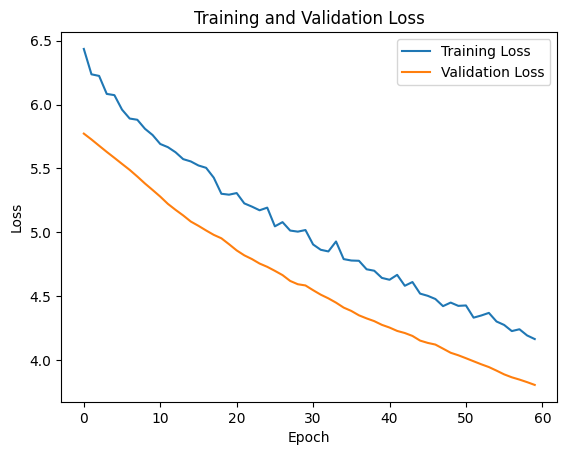

In [24]:
import matplotlib.pyplot as plt

# Assuming you have already trained the model and stored the history
#history = model.fit(train_generator, epochs=num_epochs, validation_data=val_generator)

# Plot training and validation loss values
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
